In [3]:
# pip install git+https://github.com/crunchdao/feature-engineering.git

In [304]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

tqdm.pandas()
import matplotlib.pyplot as plt

In [305]:
f_matrix = pd.read_parquet("../data/f_matrix.parquet")
b_matrix = pd.read_parquet("../data/b_matrix.parquet")

In [306]:
display(f_matrix.head())

,date,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,2016-02-17,-0.376,-0.699,-0.507,0.4536,-0.0752,-0.2548,-0.191619
1,2016-02-17,-1.121,1.073,0.234,0.4986,0.0022,0.6890,-0.596857
2,2016-02-17,-0.384,-0.097,0.100,0.9720,-0.1626,0.1913,0.562714
3,2016-02-17,-0.343,0.542,0.143,0.1034,-0.6422,-0.1259,0.988381
4,2016-02-17,-0.562,0.137,-0.213,-0.1744,-0.5152,0.0130,-0.602000


In [307]:
display(b_matrix.head())

,date,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,...,factor_74,factor_75,factor_76,factor_77,factor_78,factor_79,factor_80,factor_81,factor_82,factor_83
0,2016-02-17,0.0,0.0,0.0,0.0,0.0,0.0,-0.335,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.143,0.0,0.371,0.0,-0.083,0.0
1,2016-02-17,0.0,0.0,0.0,0.0,0.0,0.0,-0.699,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.099,0.0,0.000,0.0,-0.051,0.0
2,2016-02-17,0.0,0.0,0.0,0.0,0.0,0.0,0.084,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.020,0.0,0.000,0.0,-0.156,0.0
3,2016-02-17,0.0,0.0,0.0,0.0,0.0,0.0,0.105,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.676,0.0,1.000,0.0,-0.682,0.0
4,2016-02-17,1.0,0.0,0.0,0.0,0.0,0.0,-0.252,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.552,0.0,0.000,0.0,-0.518,0.0


In [308]:
class dev_Data:
    def __init__(self, f_matrix, b_matrix):
        """
        f_matrix:   features.parquet
        b_matrix:   factor_matrix.parquet
        """
        self.f_matrix = f_matrix
        self.b_matrix = b_matrix

    def exposure(self):
        """
        Returns: the f_exposure (measure of orthogonality of f_matrix to b_matrix)
        """

        def loc_exposure(f_mat_temp):
            features = f_mat_temp.columns[1:]
            b_mat_temp = self.b_matrix.loc[
                self.b_matrix["date"].isin(f_mat_temp["date"]),
                self.b_matrix.columns[1:],
            ]
            fact_exp_lis = []
            for feature in features:
                M = np.array(f_mat_temp[feature])
                factor_exposure = np.dot(b_mat_temp.to_numpy().T, M)
                fact_exp_lis.append(factor_exposure)
            fact_exp_matrix = np.array(fact_exp_lis)
            return fact_exp_matrix

        f_exp_matrix = self.f_matrix.groupby("date", group_keys=False).apply(lambda x: loc_exposure(x))
        return f_exp_matrix

    def orthogonalize(self, beta_coeff=0.0):
        """
        Cross-sectionally project f to be orthogonal to the subspace spanned by B,
        with respect to the dot product, in a least square sense.
        """

        def loc_orthogonalize(f_mat_temp):
            print(f'Epoch: {f_mat_temp["date"].iloc[0]}')
            features = f_mat_temp.columns[1:]
            b_mat_temp = self.b_matrix.loc[
                self.b_matrix["date"].isin(f_mat_temp["date"]),
                self.b_matrix.columns[1:],
            ]

            b_pinv_temp = np.linalg.pinv(b_mat_temp)
            for feature in features:
                m = np.array(f_mat_temp[feature])
                m_parallel = np.dot(b_mat_temp.to_numpy(), np.dot(b_pinv_temp, m))

                if beta_coeff > 0:
                    mean_bf = np.mean(np.dot(b_mat_temp.to_numpy().T, m))
                    m -= (1 - beta_coeff / mean_bf) * m_parallel
                else:
                    m -= m_parallel

                f_mat_temp[feature] = m
            return f_mat_temp

        self.f_matrix = self.f_matrix.groupby("date", group_keys=False).progress_apply(
            lambda x: loc_orthogonalize(x)
        )
        return 0

In [309]:
devdata = dev_Data(f_matrix=f_matrix, b_matrix=b_matrix)
devdata.orthogonalize(beta_coeff=0.005)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2016-02-17 00:00:00
Epoch: 2016-02-24 00:00:00
Epoch: 2016-03-02 00:00:00
Epoch: 2016-03-09 00:00:00
Epoch: 2016-03-16 00:00:00
Epoch: 2016-03-23 00:00:00
Epoch: 2016-03-30 00:00:00
Epoch: 2016-04-06 00:00:00
Epoch: 2016-04-13 00:00:00
Epoch: 2016-04-20 00:00:00
Epoch: 2016-04-27 00:00:00
Epoch: 2016-05-04 00:00:00
Epoch: 2016-05-11 00:00:00
Epoch: 2016-05-18 00:00:00
Epoch: 2016-05-25 00:00:00
Epoch: 2016-06-01 00:00:00
Epoch: 2016-06-08 00:00:00
Epoch: 2016-06-15 00:00:00
Epoch: 2016-06-22 00:00:00
Epoch: 2016-06-29 00:00:00
Epoch: 2016-07-06 00:00:00
Epoch: 2016-07-13 00:00:00
Epoch: 2016-07-20 00:00:00
Epoch: 2016-07-27 00:00:00
Epoch: 2016-08-03 00:00:00
Epoch: 2016-08-10 00:00:00
Epoch: 2016-08-17 00:00:00
Epoch: 2016-08-24 00:00:00
Epoch: 2016-08-31 00:00:00
Epoch: 2016-09-07 00:00:00
Epoch: 2016-09-14 00:00:00
Epoch: 2016-09-21 00:00:00
Epoch: 2016-09-28 00:00:00
Epoch: 2016-10-05 00:00:00
Epoch: 2016-10-12 00:00:00
Epoch: 2016-10-19 00:00:00
Epoch: 2016-10-26 00:00:00
E

0

In [310]:
exp = devdata.exposure()

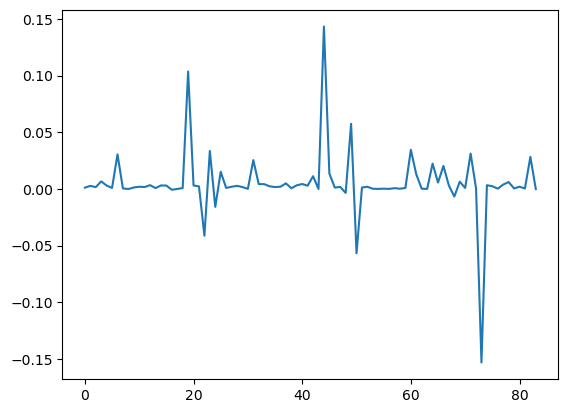

In [312]:
for i in exp.index:
    plt.plot(exp.iloc[0][1, :])

In [311]:
display(exp)

date
2016-02-17    [[-0.004937137492627697, 0.0009657269244665034...
2016-02-24    [[-0.0026960085684653023, 0.01065586828867593,...
2016-03-02    [[-0.0031775425721800588, 0.00144748428389474,...
2016-03-09    [[0.005793193255613005, -0.006763925738987431,...
2016-03-16    [[0.02939564924449556, -0.009501382597518482, ...
2016-03-23    [[-0.020488139810276085, -0.008526054551702966...
2016-03-30    [[-0.012593083577523645, 0.03359834992736077, ...
2016-04-06    [[0.0034111472936697584, -0.006704594416827914...
2016-04-13    [[0.012977701562168487, -0.012620126437913992,...
2016-04-20    [[0.005549867431459354, -0.0028554707715007233...
2016-04-27    [[-0.011425932662569416, -0.0078988980356835, ...
2016-05-04    [[0.00040026275768767494, 0.001305778435443327...
2016-05-11    [[-0.005625487903693882, 0.010354561464004042,...
2016-05-18    [[-0.034355082383850766, 0.06336948636283224, ...
2016-05-25    [[0.005883694104275805, -0.007367722135404264,...
2016-06-01    [[0.00560239861017264